In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm,rv_discrete

# ***Assignment 3***
Welcome to Assignment 3! In this assignment you are allowed to work ***individually or in pairs***. It is worth 30 points in total. Exercise 1 is worth 3 points, Exercise 2 is worth 2 points, Exercises 3 and 4 are worth 10 points each, and Exercise 5 is worth 5 points. There is a 5 point minimum for passing this assignment (you need to pass all four assignments to be able to pass the course, see the grade chart on the Canvas course page for more details).

Submission details: Your submission should contain two pdf's.

1. A pdf version of your filled out colaboratory on Canvas. You can do this by pressing `cmd/ctrl+p` (you know the drill from there).  
2. For Exercise 1, you need to hand in your hand-written solutions in a LaTeX pdf. We only accept solutions written in LaTeX, i.e. not Word or any other text editor. We recommend [Overleaf](https://overleaf.com), if you do not already have a favourite LaTeX editor (which is also [provided by KTH](https://intra.kth.se/en/it/programvara-o-system/programvara/installera/download/overleaf/overleaf-1.932755)).

# Contents
In this assignment we will cover the following topics (not necessarily in this order):
* Derivations of the Importance Weights
* Generate and Visualize the Data
* Sequential Importance Sampling
* Bootstrap Particle Filter
* Parameter Inference

# ***1. Derivations of the Importance Weights***

***For this exercise, submit your solution in a separate pdf (written in LaTeX) to avoid point deduction***

In the lectures, we saw that the importance weights in SMC can be written as

$\begin{equation}
w_n = \frac{p(y_{1:n}|x_{1:n})p(x_{1:n})}{q(x_{1:n})},
\end{equation}$
where $x_{1:n} \sim q(x_{1:n}).$

However, as we discussed, it is difficult to sample directly from $q(x_{1:n})$, and difficult to evaluate $w_n$ (when in the form above). Luckily we can make some simplifying assumptions by observing that we are dealing with a hidden Markov model (HMM). Your task is to show, based on these simplifying assumptions that,
$$w_n = \frac{p(y_{1:n}|x_{1:n})p(x_{1:n})}{q(x_{1:n})}=\alpha(x_{n})w_{n-1},$$
where
$$x_{n}\sim q(x_n|x_{n-1})$$
$$\alpha(x_{n}) =\frac{p(y_{n}|x_{n})p(x_{n}|x_{n-1})}{q(x_{n}|x_{n-1})}$$
$$w_{n-1}=\frac{p(y_{1:n-1}|x_{1:n-1})p(x_{1:n-1})}{q(x_{1:n-1})}$$

## **Hint: take the following steps**

**1) Enumerate the simplifying assumptions needed**

In the associated lecture we went through a couple of (HMM-related) assumptions and properties that should be useful.

**2) Attack the problem term by term**

Work with $p(y_{1:n}|x_{1:n})$, $p(x_{1:n})$ and $q(x_{1:n})$ separately.

**3) Put the terms together**

Once you have expressions for the three separate terms above, put them back into $w_n$ and show that you can re-write it as $$w_n =\alpha(x_{n})w_{n-1},$$



# ***2. The Stochastic Volatility Model***
In this assignment you will work with the stochastic volatililty (SV) model, which was covered in class:

$$\begin{equation*}
        p(x_1) = \mathcal{N}(0, \frac{\sigma^2}{1 - \alpha ^2}),
\end{equation*}$$

$$\begin{equation*}
        p(x_n|x_{n-1}) = \mathcal{N}(\alpha x_{n-1}, \sigma^2),
\end{equation*}$$

$$\begin{equation*}
        p(y_n|x_n) = \mathcal{N}(0,  \beta^2\exp(x_{n})),
\end{equation*}$$

for $n=1,...,T$.

Now, let $T=100$, $\beta=0.64$, $\alpha=0.91$ and $\sigma=1$, and generate data according to the SV model. Then visualize $x_{1:T}$ and $y_{1:T}$ in cells below, in a similar manner as plots in the lecture slides. ***Importantly, use correct legends, a title, and x- and y-labels. Failing to include these items will lead to point deduction. This applies for all plots in this assignment.***


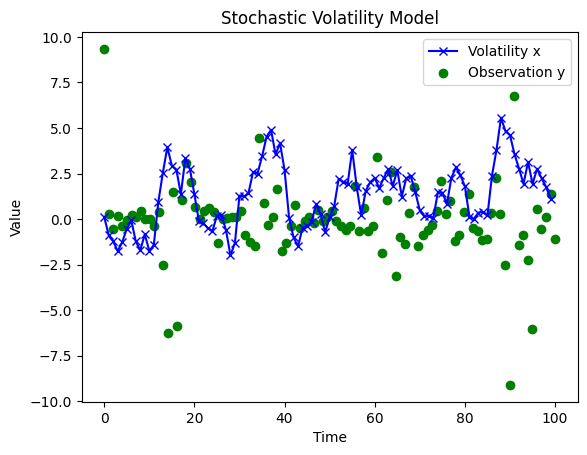

In [2]:
# Visualize the data here
np.random.seed(4)
T = 100
beta_param =0.64
alpha_param = 0.91
sigma_param = 1.0

# Generate the data
x = np.zeros(T)
y = np.zeros(T)
x[0] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)))
y[0]= np.random.normal(9,np.sqrt(beta_param**2 * np.exp(x[0])))
for i in range(1,T):
    x[i] = np.random.normal(alpha_param*x[i-1],sigma_param)
    y[i] = np.random.normal(0,np.sqrt(beta_param**2 * np.exp(x[i])))

# Plot the data
plt.figure()
plt.plot(x, '-x',label='Volatility x', color='blue')
plt.scatter(np.linspace(0,T,T),y, label='Observation y',color='green')
plt.title('Stochastic Volatility Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()


# ***3. Sequential Importance Sampling***

Here you will implement the sequential importance sampling (SIS) algorithm in order to  

1.   Estimate $x_n$ at each time step $n$.

To do so, the expression for the filtering estimate at time $n$ will be useful. Write it in the cell below:


*Write the expression for the filtering estimate here*

$ p(x_{1:n}|y_{1:n}) \approx \bar{p}(x_{1:n}|y_{1:n}) = \sum_{k=1}^{K}\tilde{w}_{n}^{(k)}\delta_{x_{1:n}^{(k)}}(x_{1:n})$

where $\tilde{w}_{n}^{(k)} = \frac{w_{n}^{(k)}}{\sum_{k=1}^{K}w_{n}^{(k)}}$


The filtering estimate above is indeed a pdf. To estimate $x_n$ use the mean of the filtering estimate at each $n$, and refer to it as $\hat{x}_n$. Report the mean squared error (MSE) between $\hat{x}_n$ and $x_n$, averaged over all $n$ (i.e., we are expecting a single value).

Additionally, you should \
2.   Visualize the degeneracy of the importance weights using a histogram for $n=2, 5, 50, 100$ \
3.   Visualize the path/trajectory degeneracy by sampling from your SIS approximation of $p(x_{1:T}|y_{1:T})$. Clearly explain how you sample from the distribution (see the lecture slides for hints)!

In order to implement the SIS, you will first need to choose a proposal distribution, $q(x_n|x_{n-1})$. For simplicity, let $q(x_n|x_{n-1}) = p(x_n|x_{n-1})$.

Start out by using $K=100$ particles.

4. How do the MSE scores change when you instead use $K=5$ and $K=500$ particles? Explain your results. **Answer in a text cell after your code cells, and report the MSEs there.**

In [3]:
class proposal(sp.stats.rv_continuous):
    def __init__(self, alpha,sigma):
        super().__init__()
        self.alpha = alpha
        self.sigma = sigma
       
    def pdf(self, x, x_prev):
        return norm.pdf(x, loc=self.alpha*x_prev, scale=self.sigma)
    
    def sample(self, x, size):
        return np.random.normal(self.alpha*x,self.sigma,size=size)
    
class transition(sp.stats.rv_continuous):
    def __init__(self, alpha,sigma):
        super().__init__()
        self.alpha = alpha
        self.sigma = sigma
       
    def pdf(self, x, x_prev):
        return norm.pdf(x, loc=self.alpha*x_prev, scale=self.sigma)
    
    def sample(self, x, size):
        return np.random.normal(self.alpha*x,self.sigma,size=size)
    
class emission(sp.stats.rv_continuous):
    def __init__(self, beta):
        super().__init__()
        self.mean = 0
        self.beta = beta
       
    def pdf(self,y,x):
        return norm.pdf(y, loc=self.mean, scale=self.beta*np.exp(x/2))
    
    def sample(self, x, size):
        return np.random.normal(self.mean,self.beta*np.exp(x/2),size=size)

def sample_particle(particles, weights):
    cat_dist = rv_discrete(name='categorical', values=(particles,weights))
    return cat_dist.rvs(size=1)[0]

In [4]:
# Implement SIS here
def sis(K,T,alpha_param,beta_param,sigma_param, x_true,y_true):

    proposal_dist = proposal(alpha_param,sigma_param)
    #transition_dist = transition(alpha_param,sigma_param)
    emission_dist = emission(beta_param)
    
    x_n_hat = np.zeros(T)
    x = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))
    x[0,:] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)),K) # Initialize the particles
    w[0,:] = emission_dist.pdf(y_true[0],x[0,:]) # Compute the weights at t = 0
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:]) # Normalize the weights
    
    for i in range(1,T):
        x[i,:] = proposal_dist.sample(x[i-1,:],K) # Sample the particles
        w[i,:] = emission_dist.pdf(y_true[i],x[i,:])*w[i-1,:] # Compute the weights
        w_normalized[i,:] = w[i,:]/np.sum(w[i,:]) # Normalize the weights
        x_n_hat[i] = np.sum(w_normalized[i,:]*x[i,:]) # Compute the estimate of x_n (TODO: check)
        

    mse = np.mean((x_n_hat - x_true)**2)

    return x, w, w_normalized, x_n_hat, mse

#### 2.

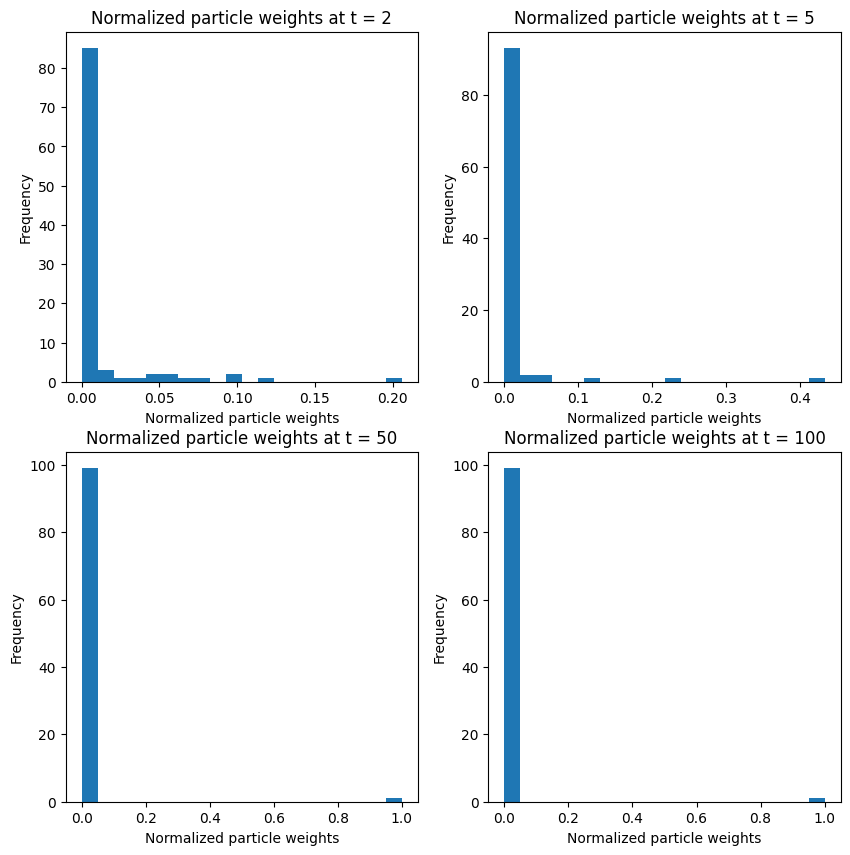

In [5]:
K = 100
x_sis,w_sis,w_normalized_sis,x_n_hat,mse = sis(K=K,T=T,alpha_param=alpha_param,
                                                     beta_param = beta_param,sigma_param=sigma_param, x_true=x,y_true=y)

# histogram of the weights
t_s = [1,4,49,99]

fig,axs=plt.subplots(2,2, figsize=(10,10))
for i,t in enumerate(t_s):
    axs[i//2,i%2].set_title('Normalized particle weights at t = '+str(t+1))
    axs[i//2,i%2].hist(w_normalized_sis[t,:],bins=20)
    
    axs[i//2,i%2].set_xlabel('Normalized particle weights')
    axs[i//2,i%2].set_ylabel('Frequency')


Text(0, 0.5, 'Normalized weight')

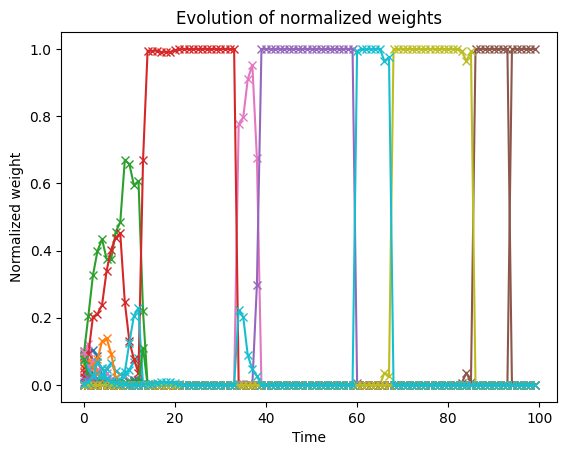

In [6]:
for i in range(K):
    plt.plot(w_normalized_sis[:,i],'-x')
plt.title('Evolution of normalized weights')
plt.xlabel('Time')
plt.ylabel('Normalized weight')

#### 3.

<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\h'
/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/777767172.py:13: SyntaxWarning: invalid escape sequence '\h'
  plt.scatter(np.linspace(0,T,T),x_n_hat,label='$\hat{x}_n$', color='blue',marker='x')
/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/777767172.py:15: SyntaxWarning: invalid escape sequence '\h'
  plt.title('$x_n$ and its estimate $\hat{x}_n$')


MSE: 6.10


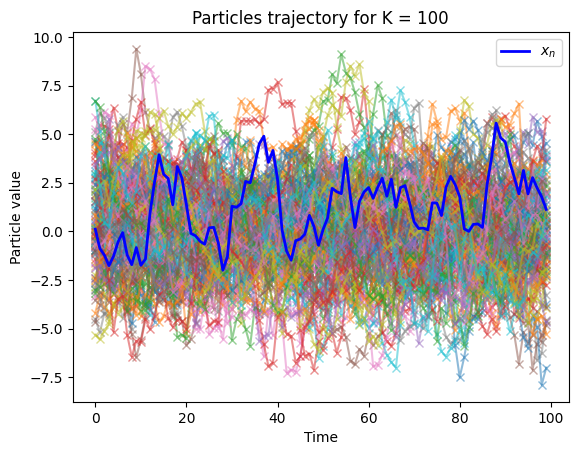

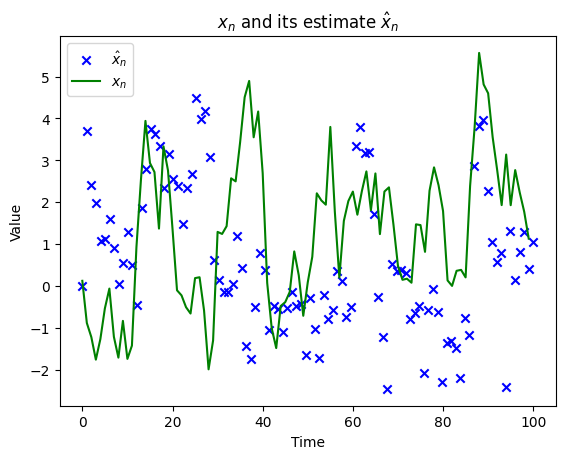

In [7]:
print('MSE: {:.2f}'.format(mse))

# Plot the particles, the samples and the estimate
for i in range(K):
    plt.plot(x_sis[:,i],'-x',alpha=0.5)
plt.plot(x,label='$x_n$', color='blue',linewidth=2)
plt.title('Particles trajectory for K = '+str(K))
plt.xlabel('Time')
plt.ylabel('Particle value')
plt.legend()
plt.show()

plt.scatter(np.linspace(0,T,T),x_n_hat,label='$\hat{x}_n$', color='blue',marker='x')
plt.plot(x,label='$x_n$', color='green')
plt.title('$x_n$ and its estimate $\hat{x}_n$')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

#### 4.

In [8]:
_,_,_,_,mse_1 = sis(K=5,T=T,alpha_param=alpha_param,beta_param = beta_param, sigma_param=sigma_param,x_true=x,y_true=y)
_,_,_,_,mse_2 = sis(K=500,T=T,alpha_param=alpha_param,beta_param = beta_param, sigma_param=sigma_param,x_true=x,y_true=y)
print('MSE for k=5: {:.2f}'.format(mse_1))
print('MSE for k=500: {:.2f}'.format(mse_2))


MSE for k=5: 7.03
MSE for k=500: 3.66


/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/3136938820.py:19: RuntimeWarning: invalid value encountered in divide
  w_normalized[i,:] = w[i,:]/np.sum(w[i,:]) # Normalize the weights
/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/3136938820.py:19: RuntimeWarning: divide by zero encountered in divide
  w_normalized[i,:] = w[i,:]/np.sum(w[i,:]) # Normalize the weights
/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/3136938820.py:19: RuntimeWarning: overflow encountered in divide
  w_normalized[i,:] = w[i,:]/np.sum(w[i,:]) # Normalize the weights


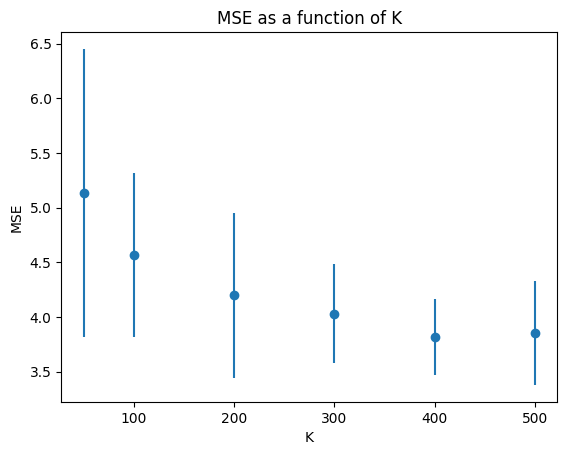

In [9]:
#IDK which behaviour we should have
K_s = [5,10,50,100,200,300,400,500]
num_runs  = 100
means = list()
vars = list()
for k in K_s:
    mse_s = list()
    for i in range(num_runs):
        _,_,_,_,mse = sis(K=k,T=T,alpha_param=alpha_param,sigma_param=sigma_param,beta_param=beta_param,x_true=x,y_true=y)
        mse_s.append(mse)
    means.append(np.mean(mse_s))
    vars.append(np.var(mse_s))

plt.figure()
plt.errorbar(K_s,means,yerr=vars,fmt='o')

plt.title('MSE as a function of K')
plt.xlabel('K')
plt.ylabel('MSE')
plt.show()
    

# ***4. Bootstrap Particle Filter***

Here you will implement the bootstrap particle filter (BPF). You will do resampling at every time step, $n$.

1.   How does the update equation for the importance weights change now that we resample at each $n$?

Do the following items using **first multinomial resampling, then stratified resampling** while clearly demonstrating how you implemented the resampling schemes:

2.   Estimate $x_n$ at each time step $n$.
3.   Visualize the degeneracy of the importance weights using a histogram for $n=2, 5, 50, 100$
4.   Visualize the path/trajectory degeneracy by sampling from your BPF approximation of $p(x_{1:T}|y_{1:T})$.

In the title of your plots, state which resampling scheme you used to produce the corresponding results. Use $K=100$.


When we apply a resampling scheme $\bar{p}(x_{1:n}|y_{1:n})$ changes as follows:,
$$\bar{p}(x_{1:n}|y_{1:n})=\sum\limits_{k=1}^K\frac{1}{k}\delta_{x_{1:n}^{a_k}}(x_{1:n})=\sum\limits_{k=1}^K\frac{m_k}{k}\delta_{x_{1:n}^k}(x_{1:n})$$
where $m_k$ is the number of times the particle with index $k$ has been resampled in our scheme.
The weights at step $n$ will be updated:
$$w_{n}^{k}=\alpha(x_n^k)w_{n-1}^{a_k}$$
Where $w_{n-1}^{a_k}=1$ and therefore $\tilde{w}_{n-1}^{a_k}=\frac{1}{K}$ for all the $a_k$ that have been resampled.

In [81]:
def multinomial(weights, K):
    return np.random.choice(K, K, p = weights)


def stratified(weights, K):
    
    N = len(weights)
    # random partition
    positions = np.zeros(N)
    for m in range(N):
        positions[m] = np.random.uniform((m-1)/N,m/N)

    indexes = np.zeros(N)
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes.astype(int)

def single_element_proposal(alpha_param, x, sigma_param):
    return np.random.normal(alpha_param*x,sigma_param)


In [86]:
# Implement BPF here
def bpf(K, T, alpha_param, sigma_param, beta_param, x_true, y_true, resampling_scheme):

    proposal_dist = proposal(alpha_param,sigma_param)
    emission_dist = emission(beta_param)

    
    x = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))

    x[0,:] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)),K) # Initialize the particles

    # here might need to set all the weights to 1/K
    w[0,:] = emission_dist.pdf(y_true[0],x[0,:]) # Compute the weights at t = 0
    # w[0,:] = np.ones(K)
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:])
    a = np.zeros(K)

    for i in range(1,T):

        x[i,:] = proposal_dist.sample(x[i-1,:],K)

        a = resampling_scheme(w_normalized[i-1,:], K)
        prov = np.zeros(K)

        for k in range(K):
            x[i,k] = single_element_proposal(alpha_param, x[i-1,a[k]], sigma_param) # Sample the particles
            prov[k] = x[i-1,a[k]]
        
        x[i-1,:] = prov
        
        # Sample the observations  
        # w[i-1,a[k]]=1, so the new weights are just equal to the alphas
        # Compute the weights
        w[i,:] = emission_dist.pdf(y_true[i],x[i,:])
        # normalize the weights
        w_normalized[i,:] = w[i,:]/np.sum(w[i,:])
 
    return x, w, w_normalized

In [96]:
def plotting_function(K, x, w_n, resampling, xtrue):

  for i in range(K):
     plt.plot(x[:,i],'-x',alpha=0.7)
  plt.plot(xtrue,label='$x_n$', color='blue',linewidth=2)
  plt.title('Particles with '+str(resampling)+' Resampling')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.show()




  for i in range(K):
      plt.plot(w_n[i,:],'-',alpha=0.7)
  plt.title('Normalized Weights '+str(resampling)+ ' Resampling')
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.show()


  t_s = [1,4,49,99]

  fig,axs=plt.subplots(2,2, figsize=(10,10))
  for i,t in enumerate(t_s):
    axs[i//2,i%2].set_title('Normalized particle weights at t = '+str(t+1))
    axs[i//2,i%2].hist(w_n[t,:],bins=20)
    
    axs[i//2,i%2].set_xlabel('Normalized particle weights')
    axs[i//2,i%2].set_ylabel('Frequency')


    

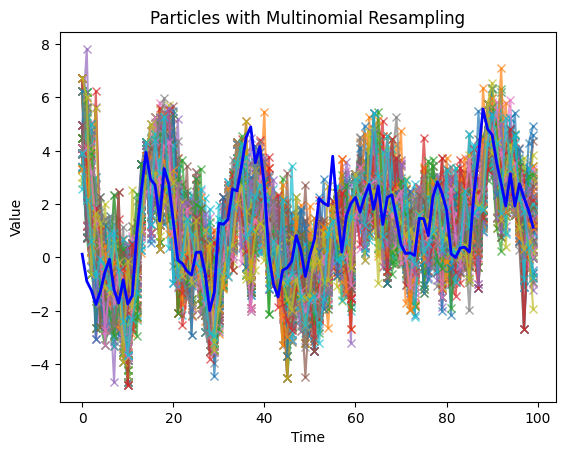

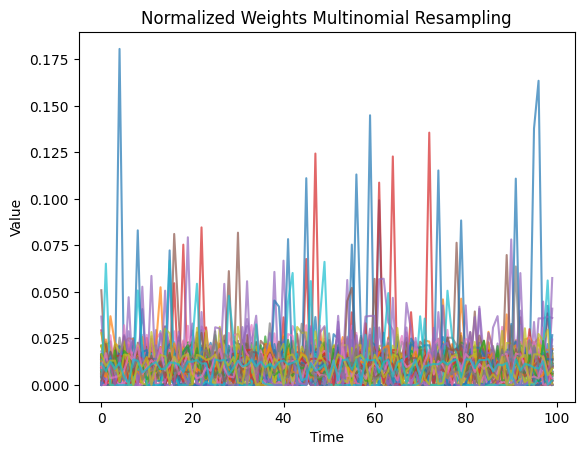

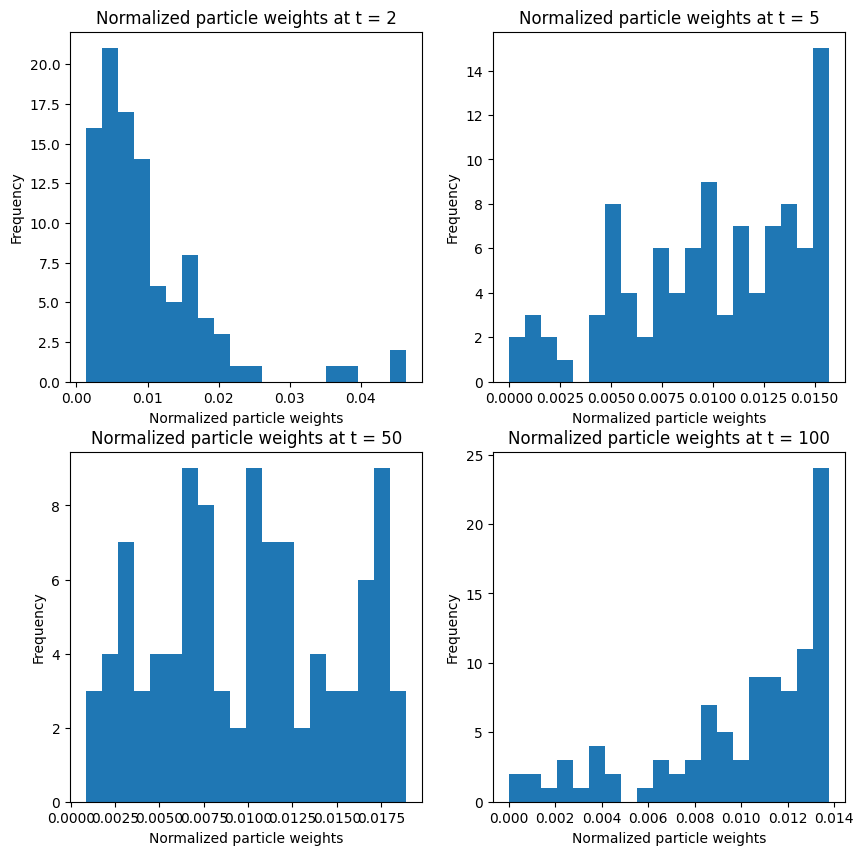

In [97]:
K = 100
T = 100
beta_param =0.64
alpha_param = 0.91
sigma_param = 1

x_bpf_m,w_bpf_m, w_normalized_bpf_m = bpf(K=K,T=T,alpha_param=alpha_param,
                                                              sigma_param=sigma_param,beta_param=beta_param,x_true=x,y_true=y,
                                                              resampling_scheme=multinomial)

# Plot the particles, the samples and the estimate

plotting_function(K, x_bpf_m, w_normalized_bpf_m, 'Multinomial', x)



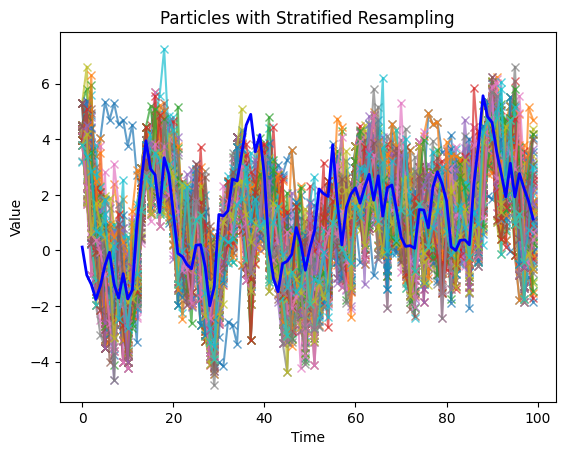

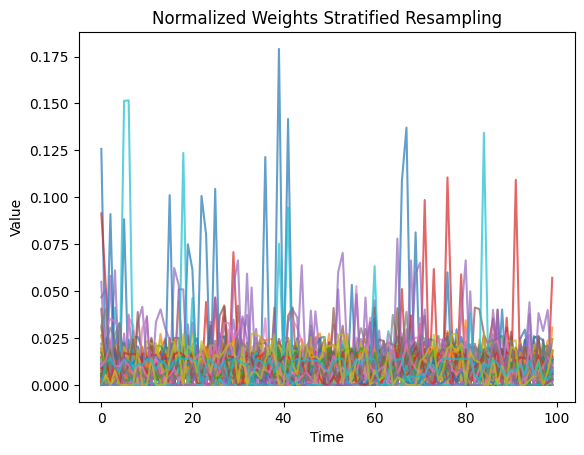

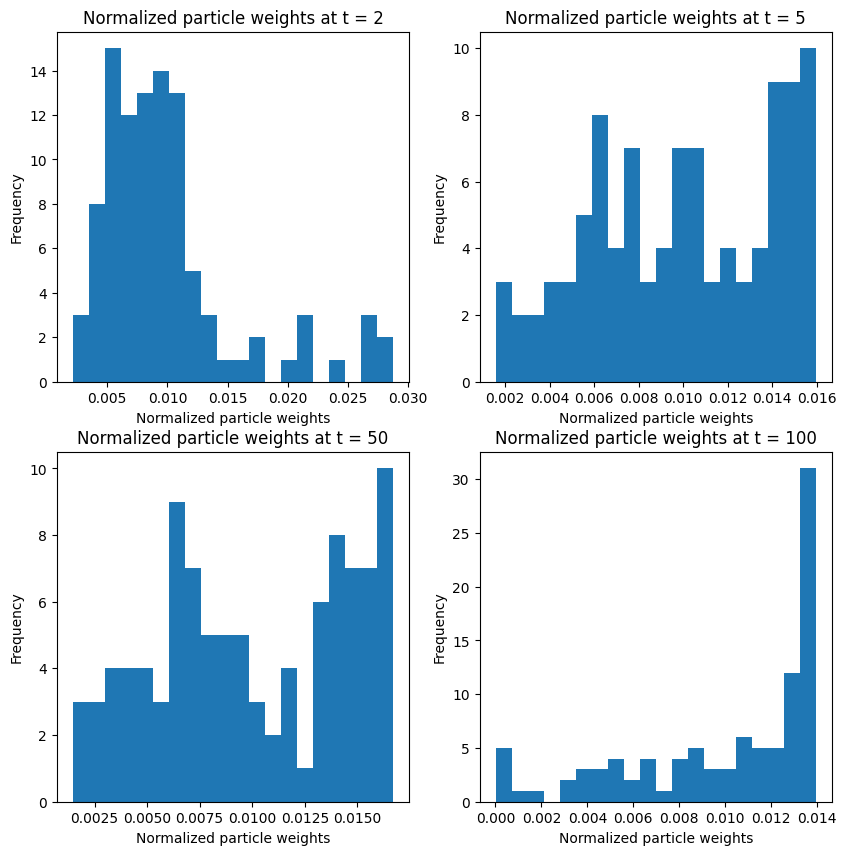

In [98]:
K = 100
T = 100
beta_param =0.64
alpha_param = 0.91
sigma_param = 1
x_bpf_s,w_bpf_s, w_normalized_bpf_s = bpf(K=K,T=T,alpha_param=alpha_param,
                                                              sigma_param=sigma_param,beta_param=beta_param,x_true=x,y_true=y,
                                                              resampling_scheme=stratified)

# Plot the particles, the samples and the estimate

plotting_function(K, x_bpf_s, w_normalized_bpf_s, 'Stratified', x)


# ***5. Parameter Inference using the Marginal Likelihood***
In SMC methods, the parameters of the model, $\theta$, are often unknown. In the SV model above, we assumed that the parameter values were $\theta=(\beta, \alpha, \sigma^2) = (0.64, 0.91, 1)$, and generated data using these values. Here, you are instead given observations, $y_{1:T}$, generated by some *unknown* parameters and $x_{1:T}$. How does one decide which parameters to use in order to infer the latent variables, $x_{1:T}$?

In the next assignment you will infer the parameters in a more sophisticated manner, using the particle Gibbs algorithm. For now you will use brute force to find a viable solution, namely through a grid search. You are to iterate over different combinations of $\theta$, and for each combination compute the marginal log-likelihood $\log p(y_{1:T}|\theta)$ (log for numerical stability).


Use the BPF algorithm and resample at every $n$. In the text cell below, type the expression for this the corresponding approximation of $p(y_{1:T}|\theta)$ (you can find it in the lecture slides):

*Type the expression for the approximation of $p(y_{1:T}|\theta)$ here, given that you use the BPF and do resampling every time step*

$$p(y_{1:n}|\theta)=\prod\limits_{i=1}^n p(y_i|y_{1:i-1},\theta)=\prod\limits_{i=1}^n \int p(y_i|x_i, \theta)p(x_i|y_{1:i-1},\theta) dx_i$$

The $p(y_i|x_i,\theta)$ are still computed as a $\mathcal{N}(0,  \beta^2\exp(x_{n}))$ and if we perform a resample, we can approximate $p(x_i|y_{i-1},\theta)$ with $\sum_k \frac{1}{K}\delta_{x_i^k}(x_i)$. Therfore the integral can be approxiamted as:

$$\int p(y_i|x_i, \theta)p(x_i|y_{1:i-1},\theta) dx_i \approx \frac{1}{K}\sum_k p(y_i|x_i^k,\theta)=\frac{1}{K}\sum_k w_i^k$$

Finally we can express the approximation of $p(y_{1:T}|\theta)$:

$$p(y_{1:T}|\theta) \approx \prod\limits_{i=1}^n (\frac{1}{K}\sum_k w_i^k)$$

Make a reasonably coarse grid (say, $8\times8\times 8$) for $\theta$ in the interval ($0$, $1$). Use the BPF with Multinomial resampling and $K=100$ to estimate the marginal log-likelihood for each pair of $\theta$ in the grid. Run the BPF 10 times (each with different random seed) for each parameter combination, and average your estimates.

Based on your results, which parameter combination would you choose?

List the top 10 parameter combinations and their corresponding likelihood scores. Comment on the results.

In [78]:
def marginal_likelihood(weights):
    return np.prod(np.sum(weights, axis = 0))

Best parameters for seed  0 : alpha =  0.4236547993389047 , beta =  0.07103605819788694 , sigma =  0.02021839744032572
Best parameters for seed  1 : alpha =  0.00011437481734488664 , beta =  0.027387593197926163 , sigma =  0.8007445686755367
Best parameters for seed  2 : alpha =  0.025926231827891333 , beta =  0.13457994534493356 , sigma =  0.8539752926394888


/var/folders/k1/3v1405w53b75v0658l_p3grc0000gn/T/ipykernel_1017/1193183346.py:39: RuntimeWarning: invalid value encountered in divide
  w_normalized[i,:] = w[i,:]/np.sum(w[i,:])


ValueError: probabilities contain NaN

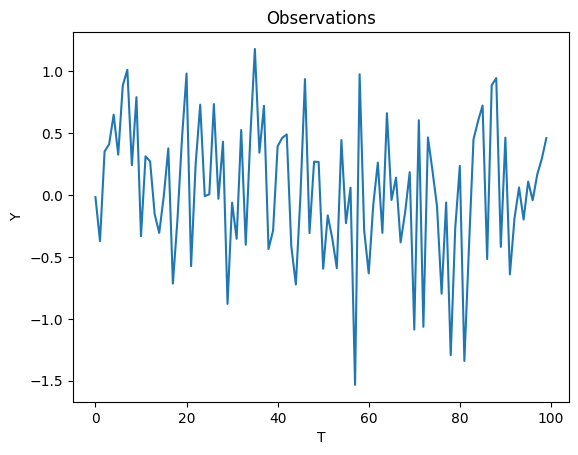

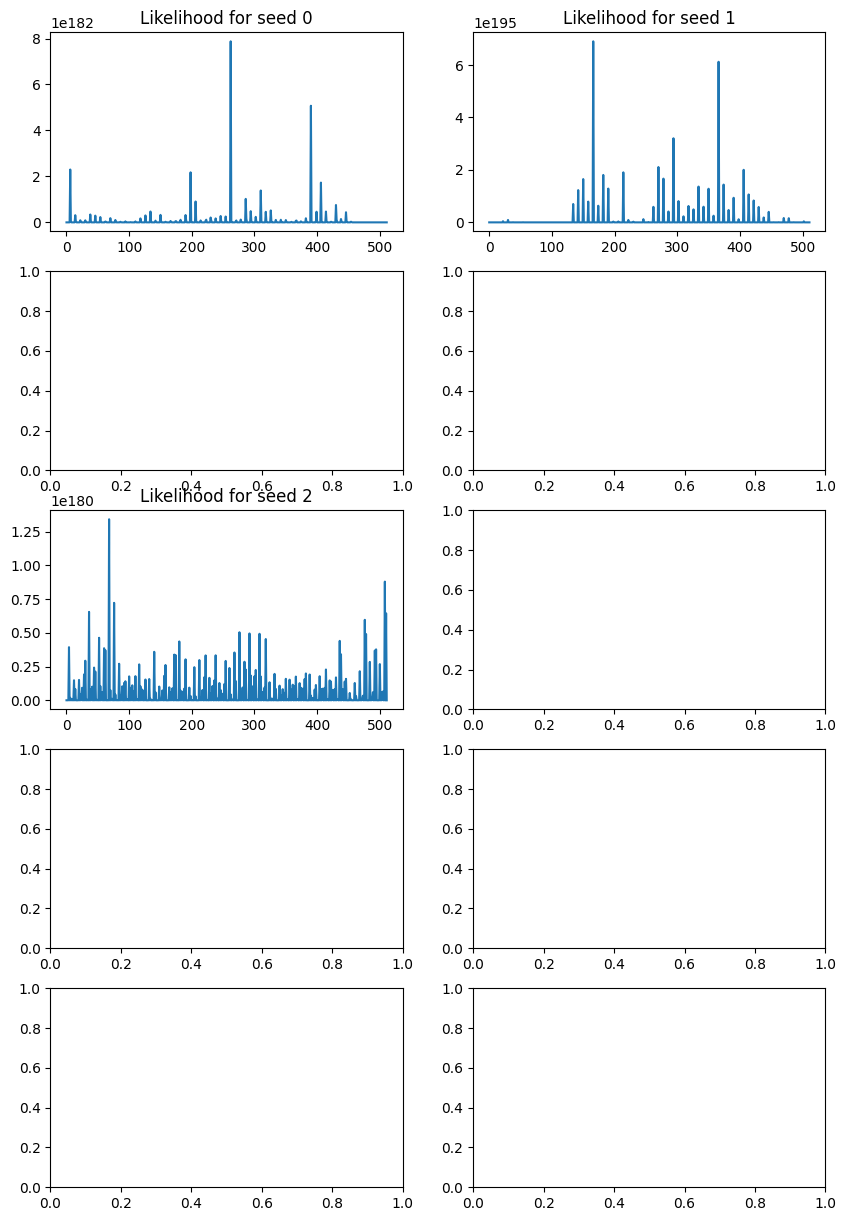

In [79]:
# load observations.npy from Canvas and do the grid search below
observations = np.load('observations.npy')
plt.plot(observations)
plt.title('Observations')
plt.xlabel('T')
plt.ylabel('Y')

K = 100
T = 100
S = 10

fig,axs = plt.subplots(5,2, figsize = (10, 15))

for s in range(S):
    np.random.seed(s)

    like = 0
    all_like = np.zeros(8*8*8)
    best_param = np.zeros(3)
    alpha = np.zeros(8)
    beta = np.zeros(8)
    sigma = np.zeros(8)
    alpha = np.random.uniform(0,1,8)
    beta = np.random.uniform(0,1,8)
    sigma = np.random.uniform(0,1,8)
    for i in range(8):
        for j in range(8):
            for l in range(8):
                __,weights_g,__ = bpf(K=K,T=T,alpha_param=alpha[i],sigma_param=np.sqrt(sigma[j]),beta_param=beta[l],x_true=x,y_true=observations,
                                                              resampling_scheme=multinomial)
                all_like[64*i+8*j+l] = marginal_likelihood(weights_g)
                if all_like[64*i+8*j+l] > like:
                    like = all_like[64*i+8*j+l]
                    best_param = [alpha[i], beta[l], sigma[j]]

    print("Best parameters for seed ", s, ": alpha = ", best_param[0], ", beta = ",  best_param[1], ", sigma = ", best_param[2])

    if s % 2 == 0:
        axs[s,0].plot(all_like)
        axs[s,0].set_title('Likelihood for seed '+str(s))
    else:
        axs[s-1,1].plot(all_like)
        axs[s-1,1].set_title('Likelihood for seed '+str(s))


